# Import Libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import label_binarize
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix, roc_curve, auc

from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE


# Data Processing

In [3]:
train_df = pd.read_csv("../../data/train_data_v2.csv")
validate_df = pd.read_csv("../../data/validate_data_v2.csv")
test_df = pd.read_csv("../../data/test_data_v2.csv")

In [4]:
print(train_df.shape)
print(validate_df.shape)
print(test_df.shape)

(8000, 47)
(1000, 47)
(1000, 47)


### Process datetime column

In [5]:
def encode_timestamp(df):
    df['Weather_Timestamp'] = pd.to_datetime(df['Weather_Timestamp'], errors='coerce')

    # Extract features
    df['Weather_Year'] = df['Weather_Timestamp'].dt.year
    df['Weather_Month'] = df['Weather_Timestamp'].dt.month
    df['Weather_Day'] = df['Weather_Timestamp'].dt.day
    df['Weather_Hour'] = df['Weather_Timestamp'].dt.hour
    df['Weather_Day_of_Week'] = df['Weather_Timestamp'].dt.dayofweek  # 0 = Monday, 6 = Sunday
    df['Weather_Is_Weekend'] = df['Weather_Day_of_Week'].isin([5, 6]).astype(int)

    df.drop(columns=['Weather_Timestamp'], inplace=True)
    return df

In [6]:
train_df = encode_timestamp(train_df)
print(f"train_df shape: {train_df.shape}")
train_df.head()

train_df shape: (8000, 52)


,ID,Severity,Start_Time,End_Time,Distance(mi),Description,Zipcode,Temperature(F),Humidity(%),Pressure(in),...,Weather_Condition_Others,Weather_Condition_Rain,Weather_Condition_Snow,Weather_Condition_Thunderstorms / Severe Weather,Weather_Year,Weather_Month,Weather_Day,Weather_Hour,Weather_Day_of_Week,Weather_Is_Weekend
0,A-547872,1,342,372,0.0,Crash on Hard Scrabble Rd at Clemson Rd.,29223-8559,77.0,88.0,29.81,...,0,0,0,0,2022,8,3,5,2,0
1,A-6997925,1,907,922,0.0,At OH-87/S Woodland Rd - Accident.,44022,75.0,65.0,28.84,...,0,0,0,0,2020,6,3,14,2,0
2,A-539957,1,603,649,0.0,Crash on Rosewood Ave at Nansemond St.,23221-3430,79.0,84.0,29.80,...,0,0,0,0,2022,8,11,9,3,0
3,A-556754,1,484,544,0.0,Crash on Gellhorn Dr at Loop Fwy.,77029,82.0,79.0,29.98,...,0,0,0,0,2022,7,25,7,0,0
4,A-7040745,1,963,993,0.0,At CR-676A/Bloomingdale Av/Progress BL - Accid...,33578,86.0,55.0,29.91,...,0,0,0,0,2020,5,20,15,2,0


In [7]:
validate_df = encode_timestamp(validate_df)
print(f"validate_df shape: {validate_df.shape}")
validate_df.head()

validate_df shape: (1000, 52)


,ID,Severity,Start_Time,End_Time,Distance(mi),Description,Zipcode,Temperature(F),Humidity(%),Pressure(in),...,Weather_Condition_Others,Weather_Condition_Rain,Weather_Condition_Snow,Weather_Condition_Thunderstorms / Severe Weather,Weather_Year,Weather_Month,Weather_Day,Weather_Hour,Weather_Day_of_Week,Weather_Is_Weekend
0,A-6171552,2,36,232,0.111,Incident on N SILVERBELL RD near N SAN JOSE AV...,85745-2626,79.0,57.0,27.07,...,0,0,0,0,2021,8,21,0,5,1
1,A-4808036,2,836,865,0.575,Stationary traffic on US-40 E from MD-43 (US-4...,21162,70.0,94.0,30.06,...,0,1,0,0,2022,7,9,13,5,1
2,A-4252512,2,1420,14,0.767,Slow traffic on I-635 W - LBJ Fwy W from New C...,75238,53.0,80.0,29.59,...,0,0,0,0,2022,3,15,23,1,0
3,A-5501729,2,472,592,0.591,Accident at exit [29A].,55369,13.0,67.0,29.39,...,0,0,0,0,2021,3,1,7,0,0
4,A-4721213,2,1273,1408,0.013,Accident on Merrydale Rd from San Rafael to Wi...,94903,36.0,100.0,30.32,...,0,0,0,0,2023,2,6,6,0,0


In [8]:
test_df = encode_timestamp(test_df)
print(f"test_df shape: {test_df.shape}")
test_df.head()

test_df shape: (1000, 52)


,ID,Severity,Start_Time,End_Time,Distance(mi),Description,Zipcode,Temperature(F),Humidity(%),Pressure(in),...,Weather_Condition_Others,Weather_Condition_Rain,Weather_Condition_Snow,Weather_Condition_Thunderstorms / Severe Weather,Weather_Year,Weather_Month,Weather_Day,Weather_Hour,Weather_Day_of_Week,Weather_Is_Weekend
0,A-6657723,2,832,1144,0.061,Slow traffic on US-1 S - FL-5 from Homestead A...,33157,73.0,59.0,30.13,...,0,0,0,0,2020,12,3,13,3,0
1,A-4877529,2,1064,1140,0.045,Incident on MN-610 WB near MISSISSIPPI RIVER D...,55444,64.0,34.0,29.28,...,0,0,0,0,2022,5,23,17,0,0
2,A-5021592,4,1060,1419,0.698,Closed road from S State Road 1 to S 300 E due...,46759-9766,94.0,52.0,29.00,...,0,0,0,0,2022,6,14,17,1,0
3,A-1158631,3,507,628,3.970,Right lane blocked due to accident on I-95 Gov...,06512,23.0,88.0,30.33,...,0,0,0,0,2021,2,10,8,2,0
4,A-1287939,3,807,990,15.580,Lane blocked due to accident on I-22 Westbound...,35594,85.0,37.0,29.18,...,0,0,0,0,2020,9,6,13,6,1


### Process categorical columns

In [9]:
for name, df in zip(['train_df', 'validate_df', 'test_df'], [train_df, validate_df, test_df]):
    print(f"--- {name} ---")
    for col in ['Wind_Direction', 'Description', 'Zipcode']:
        unique_values = df[col].unique()
        value_counts = df[col].value_counts()

        print(f"\nColumn: {col}")
        print(f"Unique values ({len(unique_values)}): {unique_values}")
        print("Value counts:")
        print(value_counts)
        print("-" * 40)
    print("\n" + "=" * 60 + "\n")



--- train_df ---

Column: Wind_Direction
Unique values (23): ['CALM' 'W' 'VAR' 'SW' 'SE' 'S' 'WSW' 'E' 'NE' 'N' 'NNW' 'SSW' 'NNE' 'NW'
 'ESE' 'ENE' 'SSE' 'WNW' 'North' 'West' 'South' 'Variable' 'East']
Value counts:
Wind_Direction
CALM        1301
S            641
W            553
SSW          457
N            427
SW           420
WNW          416
SSE          383
WSW          382
VAR          378
NW           372
E            363
NNW          334
SE           326
NNE          294
ESE          274
ENE          273
NE           245
East          43
South         39
North         37
West          26
Variable      16
Name: count, dtype: int64
----------------------------------------

Column: Description
Unique values (7823): ['Crash on Hard Scrabble Rd at Clemson Rd.'
 'At OH-87/S Woodland Rd - Accident.'
 'Crash on Rosewood Ave at Nansemond St.' ...
 'At Pleasant Hill Rd - Accident.'
 'Closed at US-220-BR/VA-457/Memorial Blvd - Road closed due to accident.'
 'Closed between CR-19/S Cente

In [10]:
def encode_categorical(df, reference_columns=None):
    # One-hot encode 'Wind_Direction'
    df = pd.get_dummies(df, columns=['Wind_Direction'], drop_first=True)

    # Convert True/False to 0/1 after encoding
    for col in df.select_dtypes(include=['bool']).columns:
        df[col] = df[col].astype(int)

    # Ensure consistent columns for validate/test DataFrame
    if reference_columns is not None:
        missing_cols = [col for col in reference_columns if col not in df.columns]
        for col in missing_cols:
            df[col] = 0  # Add missing columns with 0s
        df = df[reference_columns]

    return df

In [11]:
train_df = encode_categorical(train_df)
print(f"train_df shape: {train_df.shape}")
train_df.head()

train_df shape: (8000, 73)


,ID,Severity,Start_Time,End_Time,Distance(mi),Description,Zipcode,Temperature(F),Humidity(%),Pressure(in),...,Wind_Direction_SSE,Wind_Direction_SSW,Wind_Direction_SW,Wind_Direction_South,Wind_Direction_VAR,Wind_Direction_Variable,Wind_Direction_W,Wind_Direction_WNW,Wind_Direction_WSW,Wind_Direction_West
0,A-547872,1,342,372,0.0,Crash on Hard Scrabble Rd at Clemson Rd.,29223-8559,77.0,88.0,29.81,...,0,0,0,0,0,0,0,0,0,0
1,A-6997925,1,907,922,0.0,At OH-87/S Woodland Rd - Accident.,44022,75.0,65.0,28.84,...,0,0,0,0,0,0,1,0,0,0
2,A-539957,1,603,649,0.0,Crash on Rosewood Ave at Nansemond St.,23221-3430,79.0,84.0,29.80,...,0,0,0,0,1,0,0,0,0,0
3,A-556754,1,484,544,0.0,Crash on Gellhorn Dr at Loop Fwy.,77029,82.0,79.0,29.98,...,0,0,0,0,0,0,0,0,0,0
4,A-7040745,1,963,993,0.0,At CR-676A/Bloomingdale Av/Progress BL - Accid...,33578,86.0,55.0,29.91,...,0,0,1,0,0,0,0,0,0,0


In [12]:
validate_df = encode_categorical(validate_df, reference_columns=train_df.columns)
print(f"validate_df shape: {validate_df.shape}")
validate_df.head()

validate_df shape: (1000, 73)


,ID,Severity,Start_Time,End_Time,Distance(mi),Description,Zipcode,Temperature(F),Humidity(%),Pressure(in),...,Wind_Direction_SSE,Wind_Direction_SSW,Wind_Direction_SW,Wind_Direction_South,Wind_Direction_VAR,Wind_Direction_Variable,Wind_Direction_W,Wind_Direction_WNW,Wind_Direction_WSW,Wind_Direction_West
0,A-6171552,2,36,232,0.111,Incident on N SILVERBELL RD near N SAN JOSE AV...,85745-2626,79.0,57.0,27.07,...,1,0,0,0,0,0,0,0,0,0
1,A-4808036,2,836,865,0.575,Stationary traffic on US-40 E from MD-43 (US-4...,21162,70.0,94.0,30.06,...,0,0,0,0,0,0,0,0,0,0
2,A-4252512,2,1420,14,0.767,Slow traffic on I-635 W - LBJ Fwy W from New C...,75238,53.0,80.0,29.59,...,0,0,0,0,0,0,0,0,0,0
3,A-5501729,2,472,592,0.591,Accident at exit [29A].,55369,13.0,67.0,29.39,...,0,0,0,0,0,0,0,0,0,0
4,A-4721213,2,1273,1408,0.013,Accident on Merrydale Rd from San Rafael to Wi...,94903,36.0,100.0,30.32,...,0,0,0,0,0,0,0,0,0,0


In [13]:
test_df = encode_categorical(test_df, reference_columns=train_df.columns)
print(f"test_df shape: {test_df.shape}")
test_df.head()

test_df shape: (1000, 73)


,ID,Severity,Start_Time,End_Time,Distance(mi),Description,Zipcode,Temperature(F),Humidity(%),Pressure(in),...,Wind_Direction_SSE,Wind_Direction_SSW,Wind_Direction_SW,Wind_Direction_South,Wind_Direction_VAR,Wind_Direction_Variable,Wind_Direction_W,Wind_Direction_WNW,Wind_Direction_WSW,Wind_Direction_West
0,A-6657723,2,832,1144,0.061,Slow traffic on US-1 S - FL-5 from Homestead A...,33157,73.0,59.0,30.13,...,0,0,0,0,0,0,0,0,0,0
1,A-4877529,2,1064,1140,0.045,Incident on MN-610 WB near MISSISSIPPI RIVER D...,55444,64.0,34.0,29.28,...,1,0,0,0,0,0,0,0,0,0
2,A-5021592,4,1060,1419,0.698,Closed road from S State Road 1 to S 300 E due...,46759-9766,94.0,52.0,29.00,...,0,1,0,0,0,0,0,0,0,0
3,A-1158631,3,507,628,3.970,Right lane blocked due to accident on I-95 Gov...,06512,23.0,88.0,30.33,...,0,0,0,0,0,0,0,0,0,0
4,A-1287939,3,807,990,15.580,Lane blocked due to accident on I-22 Westbound...,35594,85.0,37.0,29.18,...,0,0,0,0,0,0,0,0,0,0


### Drop irrelevant columns

In [14]:
irrelevant_columns = ["ID", "Description", "Zipcode"]
train_df = train_df.drop(columns=irrelevant_columns, errors='ignore')
validate_df = validate_df.drop(columns=irrelevant_columns, errors='ignore')
test_df = test_df.drop(columns=irrelevant_columns, errors='ignore')

# Evaluation Function

In [15]:
def evaluate(y_pred, y_test, X_test, model):
    # Evaluate the model
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))
    print("Classification Report:\n", classification_report(y_test, y_pred))

    # Compute and display confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:\n", conf_matrix)

    # Compute AUC-ROC curve
    y_test_bin = label_binarize(y_test, classes=[1, 2, 3, 4])
    y_pred_prob = model.predict_proba(X_test)
    n_classes = y_test_bin.shape[1]

    plt.figure()
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
        plt.plot(fpr, tpr, label=f'Class {i+1} (AUC = {auc(fpr, tpr):.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-Class ROC Curve')
    plt.legend(loc='best')
    plt.show()

# Define Features & Target

In [16]:
# Define features and target
X_train = train_df.drop(columns=["Severity"])
y_train = train_df["Severity"]

X_validate = validate_df.drop(columns=["Severity"])
y_validate = validate_df["Severity"]

X_test = test_df.drop(columns=["Severity"])
y_test = test_df["Severity"]


# Baseline Model

In [16]:

# Train the Random Forest model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_validate)

Accuracy: 0.803
F1 Score: 0.8375722195740589
Classification Report:
               precision    recall  f1-score   support

           1       0.40      1.00      0.57        14
           2       1.00      0.77      0.87       838
           3       0.62      0.94      0.75       124
           4       0.19      1.00      0.32        24

    accuracy                           0.80      1000
   macro avg       0.55      0.93      0.63      1000
weighted avg       0.92      0.80      0.84      1000

Confusion Matrix:
 [[ 14   0   0   0]
 [ 20 648  73  97]
 [  1   3 117   3]
 [  0   0   0  24]]


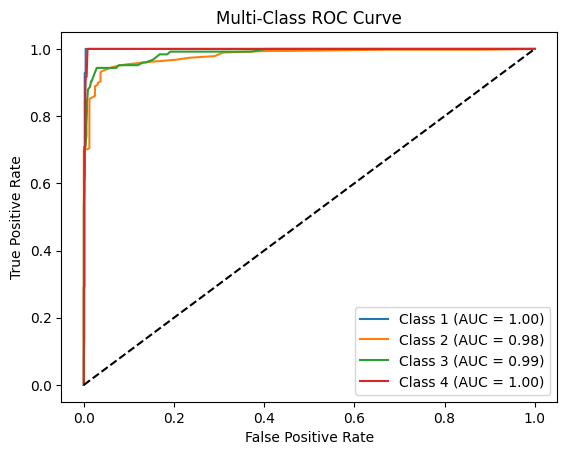

In [17]:
evaluate(y_pred, y_validate, X_validate, model)


Accuracy: 0.764
F1 Score: 0.8098897781466786
Classification Report:
               precision    recall  f1-score   support

           1       0.20      1.00      0.33         6
           2       1.00      0.73      0.84       847
           3       0.59      0.97      0.73       119
           4       0.17      1.00      0.30        28

    accuracy                           0.76      1000
   macro avg       0.49      0.92      0.55      1000
weighted avg       0.92      0.76      0.81      1000

Confusion Matrix:
 [[  6   0   0   0]
 [ 23 615  79 130]
 [  1   1 115   2]
 [  0   0   0  28]]


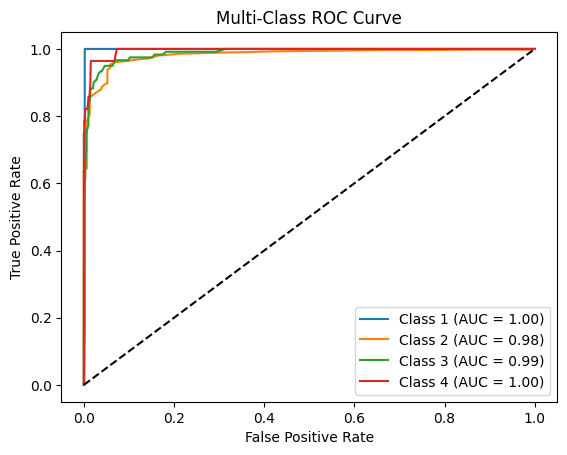

In [18]:
y_pred = model.predict(X_test)
evaluate(y_pred, y_test, X_test, model)


# Backward Selection

Accuracy: 0.809
F1 Score: 0.8420315674625483
Classification Report:
               precision    recall  f1-score   support

           1       0.42      1.00      0.60        14
           2       1.00      0.78      0.87       838
           3       0.62      0.95      0.75       124
           4       0.20      1.00      0.33        24

    accuracy                           0.81      1000
   macro avg       0.56      0.93      0.64      1000
weighted avg       0.92      0.81      0.84      1000

Confusion Matrix:
 [[ 14   0   0   0]
 [ 19 653  72  94]
 [  0   3 118   3]
 [  0   0   0  24]]


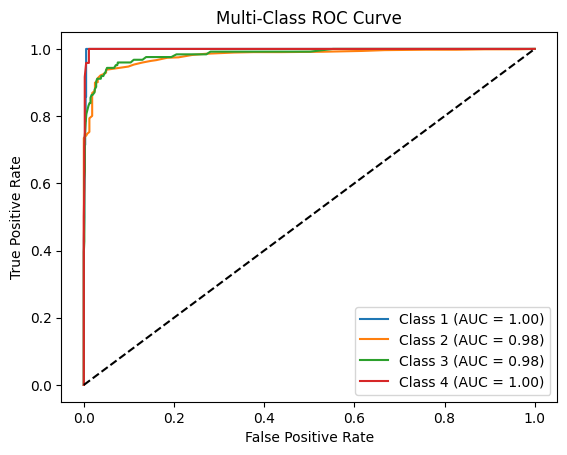

Accuracy: 0.776
F1 Score: 0.8178589131925353
Classification Report:
               precision    recall  f1-score   support

           1       0.23      1.00      0.38         6
           2       1.00      0.74      0.85       847
           3       0.59      0.97      0.73       119
           4       0.19      1.00      0.31        28

    accuracy                           0.78      1000
   macro avg       0.50      0.93      0.57      1000
weighted avg       0.92      0.78      0.82      1000

Confusion Matrix:
 [[  6   0   0   0]
 [ 20 626  81 120]
 [  0   1 116   2]
 [  0   0   0  28]]


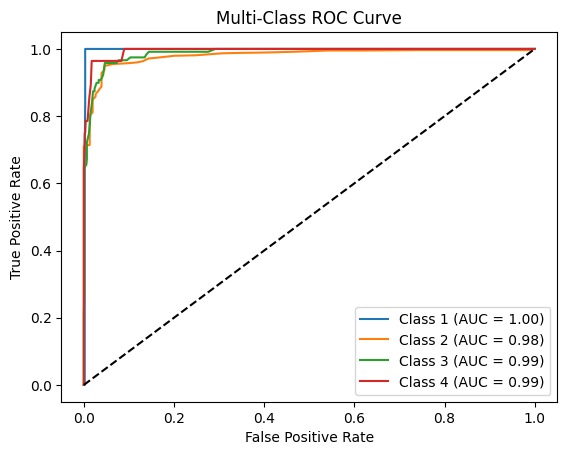

In [22]:

# Initialize the Random Forest model
model = RandomForestClassifier(random_state=42)

# Perform Recursive Feature Elimination (RFE)
selector = RFE(model, step=1)  # Adjust step for faster elimination if needed
selector.fit(X_train, y_train)

# Get selected features
selected_features = X_train.columns[selector.support_]

# Transform both training and validation datasets
X_train_selected = selector.transform(X_train)
X_validate_selected = selector.transform(X_validate)
X_test_selected = selector.transform(X_test)  # Apply to test set as well

# Train a new Random Forest model on the reduced feature set
model.fit(X_train_selected, y_train)

# Make predictions
y_pred_validate = model.predict(X_validate_selected)

# Evaluate the model
evaluate(y_pred_validate, y_validate, X_validate_selected, model)

# Make predictions on the test set
y_pred_test = model.predict(X_test_selected)
evaluate(y_pred_test, y_test, X_test_selected, model)


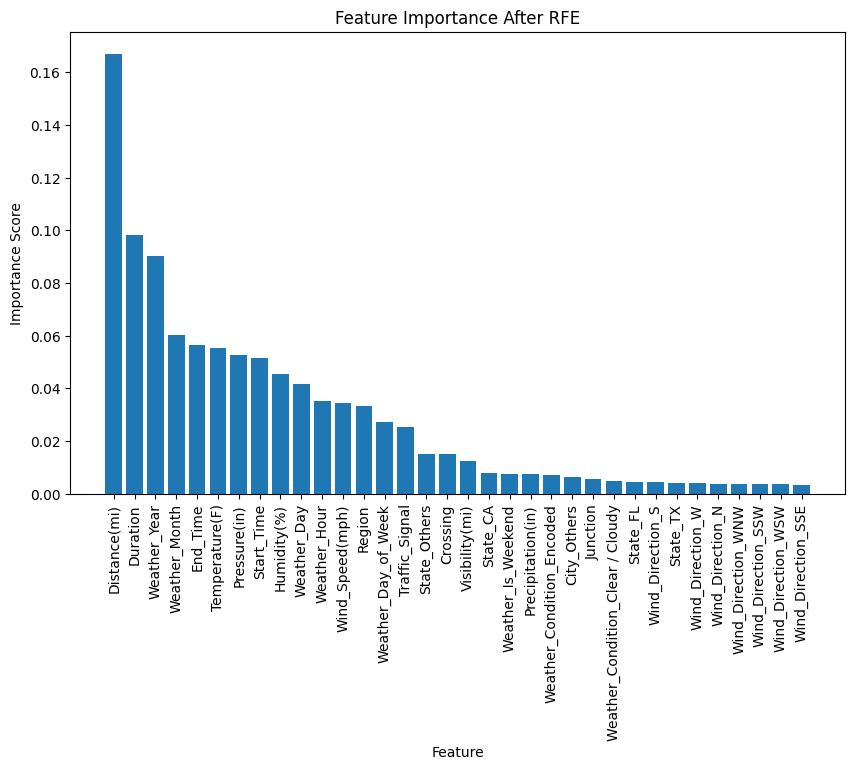

In [25]:
import numpy as np

# Extract feature importance
feature_importance = model.feature_importances_

# Sort feature importance for better visualization
indices = np.argsort(feature_importance)[::-1]

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.title("Feature Importance After RFE")
plt.bar(range(len(selected_features)), feature_importance[indices], align="center")
plt.xticks(range(len(selected_features)), np.array(selected_features)[indices], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance Score")
plt.show()


# Parameter Tuning

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
[CV] END ccp_alpha=0.0, max_depth=None, max_samples=None, min_samples_split=2, n_estimators=50; total time=   1.1s
[CV] END ccp_alpha=0.0, max_depth=None, max_samples=None, min_samples_split=2, n_estimators=50; total time=   1.1s
[CV] END ccp_alpha=0.0, max_depth=None, max_samples=None, min_samples_split=2, n_estimators=50; total time=   1.2s
[CV] END ccp_alpha=0.0, max_depth=None, max_samples=None, min_samples_split=2, n_estimators=50; total time=   1.2s
[CV] END ccp_alpha=0.0, max_depth=None, max_samples=None, min_samples_split=2, n_estimators=50; total time=   1.2s
[CV] END ccp_alpha=0.0, max_depth=None, max_samples=None, min_samples_split=2, n_estimators=100; total time=   2.3s
[CV] END ccp_alpha=0.0, max_depth=None, max_samples=None, min_samples_split=2, n_estimators=100; total time=   2.3s
[CV] END ccp_alpha=0.0, max_depth=None, max_samples=None, min_samples_split=2, n_estimators=100; total time=   2.4s
[CV] END ccp_

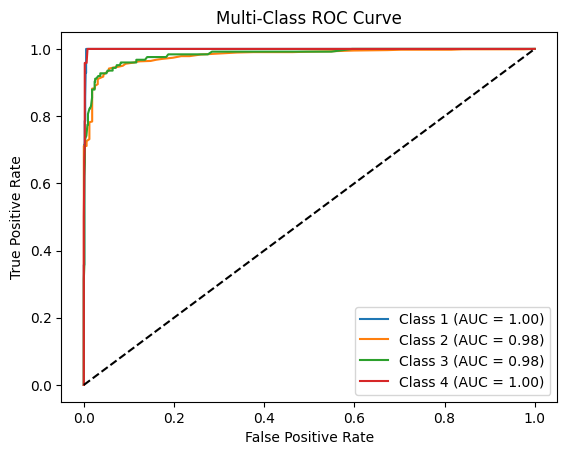

In [17]:
# Perform Recursive Feature Elimination (RFE)
selector = RFE(RandomForestClassifier(random_state=42), step=1)
selector.fit(X_train, y_train)

# Select only important features
X_train_selected = selector.transform(X_train)
X_validate_selected = selector.transform(X_validate)
X_test_selected = selector.transform(X_test)

# Define the parameter grid for tuning
param_grid = {
    'n_estimators': [50, 100, 150],  
    'max_depth': [None, 10, 20, 30],  
    'min_samples_split': [2, 5, 10],  
    'ccp_alpha': [0.0, 0.01, 0.1],  
    'max_samples': [None, 0.5, 0.8]  
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    verbose=2
)

# Fit the grid search to the **selected feature** training data
grid_search.fit(X_train_selected, y_train)

# Get the best model from the grid search
best_model = grid_search.best_estimator_

# Print the best parameters found
print("Best parameters found: ", grid_search.best_params_)

# Make predictions using the best model on the validation set
y_pred_validate = best_model.predict(X_validate_selected)

# Evaluate
print("\nEvaluate (Validation Set):")
evaluate(y_pred_validate, y_validate, X_validate_selected, best_model)



Best parameters found:  {'ccp_alpha': 0.0, 'max_depth': None, 'max_samples': None, 'min_samples_split': 2, 'n_estimators': 150}

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END ccp_alpha=0, max_depth=None, max_samples=None, min_samples_split=1, n_estimators=130; total time=   0.0s
[CV] END ccp_alpha=0, max_depth=None, max_samples=None, min_samples_split=1, n_estimators=170; total time=   0.0s
[CV] END ccp_alpha=0, max_depth=None, max_samples=None, min_samples_split=1, n_estimators=130; total time=   0.0s
[CV] END ccp_alpha=0, max_depth=None, max_samples=None, min_samples_split=1, n_estimators=130; total time=   0.0s[CV] END ccp_alpha=0, max_depth=None, max_samples=None, min_samples_split=1, n_estimators=130; total time=   0.0s[CV] END ccp_alpha=0, max_depth=None, max_samples=None, min_samples_split=1, n_estimators=170; total time=   0.0s


[CV] END ccp_alpha=0, max_depth=None, max_samples=None, min_samples_split=1, n_estimators=130; total time=   0.0s
[CV] END ccp_alpha=0, max_depth=None, max_samples=None, min_samples_split=1, n_estimators=170; total time=   0.0s
[CV] END ccp_alpha=0, max

/Users/winlaeyee/Downloads/traffic_accident_severity_prediction/venv/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
180 fits failed out of a total of 540.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
180 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/winlaeyee/Downloads/traffic_accident_severity_prediction/venv/lib/python3.13/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/winlaeyee/Downloads/traffic_accident_severity_prediction/venv/lib/python3.13/site-packages/sklearn/base.py", line 1382, in wrapper
 

Best parameters found:  {'ccp_alpha': 0, 'max_depth': None, 'max_samples': None, 'min_samples_split': 3, 'n_estimators': 200}

Evaluate (Validation Set):
Accuracy: 0.813
F1 Score: 0.845439481560354
Classification Report:
               precision    recall  f1-score   support

           1       0.44      1.00      0.61        14
           2       1.00      0.78      0.88       838
           3       0.63      0.96      0.76       124
           4       0.20      1.00      0.33        24

    accuracy                           0.81      1000
   macro avg       0.57      0.94      0.64      1000
weighted avg       0.92      0.81      0.85      1000

Confusion Matrix:
 [[ 14   0   0   0]
 [ 18 656  71  93]
 [  0   2 119   3]
 [  0   0   0  24]]


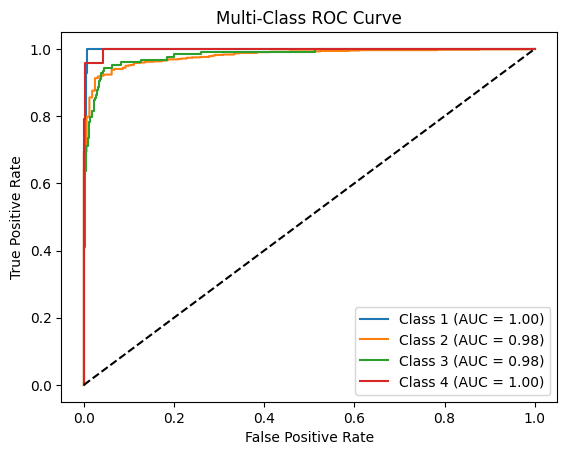

In [20]:
# Perform Recursive Feature Elimination (RFE)
selector = RFE(RandomForestClassifier(random_state=42), step=1)
selector.fit(X_train, y_train)

# Select only important features
X_train_selected = selector.transform(X_train)
X_validate_selected = selector.transform(X_validate)
X_test_selected = selector.transform(X_test)

# Define the parameter grid for tuning
param_grid = {
    'n_estimators': [130, 170, 200],  
    'max_depth': [None, 5],  
    'min_samples_split': [1, 3, 7],  
    'ccp_alpha': [0, 0.001],  
    'max_samples': [None, 0.2, 0.4]  
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    verbose=2
)

# Fit the grid search to the **selected feature** training data
grid_search.fit(X_train_selected, y_train)

# Get the best model from the grid search
best_model_second = grid_search.best_estimator_

# Print the best parameters found
print("Best parameters found: ", grid_search.best_params_)

# Make predictions using the best model on the validation set
y_pred_validate = best_model_second.predict(X_validate_selected)

# Evaluate
print("\nEvaluate (Validation Set):")
evaluate(y_pred_validate, y_validate, X_validate_selected, best_model_second)



 {'ccp_alpha': 0, 'max_depth': None, 'max_samples': None, 'min_samples_split': 3, 'n_estimators': 200}

In [ ]:
# # Perform Recursive Feature Elimination (RFE)
# selector = RFE(RandomForestClassifier(random_state=42), step=1)
# selector.fit(X_train, y_train)

# # Select only important features
# X_train_selected = selector.transform(X_train)
# X_validate_selected = selector.transform(X_validate)
# X_test_selected = selector.transform(X_test)

# # Define the parameter grid for tuning
# param_grid = {
#     'n_estimators': [50, 100, 150],  
#     'criterion': ["gini", "entropy", "log_loss"],  
#     'max_depth': [None, 10, 20, 30],  
#     'min_samples_split': [2, 5, 10],  
#     'min_samples_leaf': [1, 2, 4],  
#     'min_weight_fraction_leaf': [0.0, 0.1, 0.2],  
#     'max_features': [None, 'sqrt', 'log2'],  
#     'max_leaf_nodes': [None, 10, 20, 50],  
#     'min_impurity_decrease': [0.0, 0.01, 0.1],  
#     'bootstrap': [True],  
#     'oob_score': [True],  # Only valid when bootstrap=True  
#     'warm_start': [True, False],  
#     'ccp_alpha': [0.0, 0.01, 0.1],  
#     'max_samples': [None, 0.5, 0.8]  
# }

# # Initialize GridSearchCV
# grid_search = GridSearchCV(
#     estimator=RandomForestClassifier(random_state=42),
#     param_grid=param_grid,
#     cv=5,
#     n_jobs=-1,
#     verbose=2
# )

# # Fit the grid search to the **selected feature** training data
# grid_search.fit(X_train_selected, y_train)

# # Get the best model from the grid search
# best_model = grid_search.best_estimator_

# # Print the best parameters found
# print("Best parameters found: ", grid_search.best_params_)

# # Make predictions using the best model on the validation set
# y_pred_validate = best_model.predict(X_validate_selected)

# # Evaluate
# print("\nEvaluate (Validation Set):")
# evaluate(y_pred_validate, y_validate, X_validate_selected, best_model)



Evaluate (Test Set):
Accuracy: 0.774
F1 Score: 0.8166661235220327
Classification Report:
               precision    recall  f1-score   support

           1       0.23      1.00      0.38         6
           2       1.00      0.74      0.85       847
           3       0.59      0.97      0.74       119
           4       0.18      1.00      0.31        28

    accuracy                           0.77      1000
   macro avg       0.50      0.93      0.57      1000
weighted avg       0.92      0.77      0.82      1000

Confusion Matrix:
 [[  6   0   0   0]
 [ 20 624  80 123]
 [  0   1 116   2]
 [  0   0   0  28]]


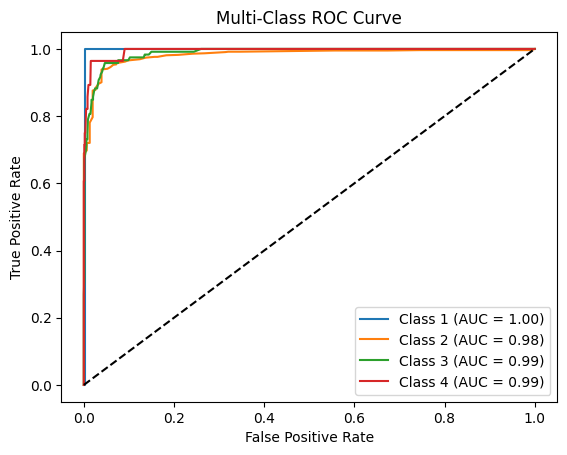

In [21]:

# Predict on the test set using the best model
y_pred_test = best_model.predict(X_test_selected)

# Evaluate
print("\nEvaluate (Test Set):")
evaluate(y_pred_test, y_test, X_test_selected, best_model)


Evaluate (Test Set):
Accuracy: 0.772
F1 Score: 0.8152202759025806
Classification Report:
               precision    recall  f1-score   support

           1       0.23      1.00      0.38         6
           2       1.00      0.74      0.85       847
           3       0.59      0.97      0.73       119
           4       0.18      1.00      0.31        28

    accuracy                           0.77      1000
   macro avg       0.50      0.93      0.57      1000
weighted avg       0.92      0.77      0.82      1000

Confusion Matrix:
 [[  6   0   0   0]
 [ 20 623  79 125]
 [  0   2 115   2]
 [  0   0   0  28]]


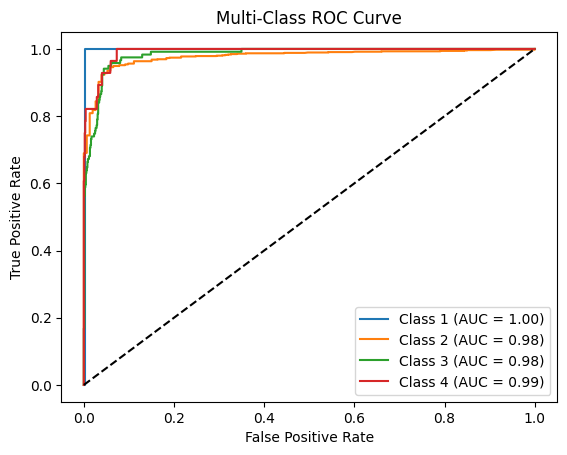

In [22]:

# Predict on the test set using the best model
y_pred_test = best_model_second.predict(X_test_selected)

# Evaluate
print("\nEvaluate (Test Set):")
evaluate(y_pred_test, y_test, X_test_selected, best_model_second)